<a href="https://colab.research.google.com/github/muhzinmohammed/RUL_CEEMDAN-DNN-BiLSTM/blob/main/CEEMDAN_%2B_DNN_%2B_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ======================================================
# Install dependencies
# ======================================================
!pip install EMD-signal scikit-learn tensorflow matplotlib tqdm


In [ ]:
# ======================================================
# Imports, seed and helper function
# ======================================================
import os
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.io import loadmat
from PyEMD import CEEMDAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Small plotting helper
def plot_series(series_list, labels=None, title=None, figsize=(10,4)):
    plt.figure(figsize=figsize)
    for i, s in enumerate(series_list):
        lbl = labels[i] if labels else None
        plt.plot(s, label=lbl)
    if labels: plt.legend()
    if title: plt.title(title)
    plt.xlabel("Cycle")
    plt.ylabel("Capacity (relative or units)")
    plt.grid(True)
    plt.show()


In [ ]:
# ======================================================
# Uploading Dataset
# ======================================================
from google.colab import files
print("Upload B0005.mat, B0006.mat, B0007.mat, and B0018.mat now (select files).")
uploaded = files.upload()
print("Uploaded:", list(uploaded.keys()))


Upload B0005.mat, B0006.mat, B0007.mat, and B0018.mat now (select files).


Saving B0005.mat to B0005.mat
Saving B0006.mat to B0006.mat
Saving B0007.mat to B0007.mat
Saving B0018.mat to B0018.mat
Uploaded: ['B0005.mat', 'B0006.mat', 'B0007.mat', 'B0018.mat']


In [ ]:
# ======================================================
# Capacity extraction from dataset
# ======================================================
def extract_capacity_from_nasa_mat(mat):

    cell_keys = [k for k in mat.keys() if isinstance(k, str) and k.startswith('B')]
    if len(cell_keys) == 0:
        raise ValueError("No key starting with 'B' found in .mat file. Inspect mat.keys()")
    key = cell_keys[0]
    try:
        recs = mat[key][0,0]['cycle'][0]
    except Exception as e:
        raise ValueError(f"Unexpected .mat layout for key {key}: {e}")
    caps = []
    for r in recs:

        try:
            if 'data' in r.dtype.names and 'Capacity' in r['data'][0,0].dtype.names:
                c = r['data'][0,0]['Capacity'][0,0]
                caps.append(float(c))
            else:
                for name in r.dtype.names:
                    fld = r[name]
                    if isinstance(fld, (np.ndarray, list)) and np.asarray(fld).size>0:
                        pass
        except Exception:
            pass
    if len(caps) == 0:
        def recursive_search(obj):
            if isinstance(obj, dict):
                for v in obj.values():
                    res = recursive_search(v)
                    if res is not None:
                        return res
            elif isinstance(obj, np.ndarray):
                a = np.atleast_1d(obj)
                if a.dtype.kind in 'fiu' and a.size > 10:
                    if np.sum(np.diff(a) < 0) > a.size * 0.5:
                        return a.astype(float)
            elif hasattr(obj, '__dict__'):
                for v in vars(obj).values():
                    res = recursive_search(v)
                    if res is not None:
                        return res
            return None
        candidate = recursive_search(mat)
        if candidate is None:
            raise ValueError("Could not extract capacity from .mat file automatically. Inspect mat keys and structure.")
        return candidate
    return np.array(caps, dtype=float)

file_caps = {}
for fname in uploaded.keys():
    mat = loadmat(fname)
    cap = extract_capacity_from_nasa_mat(mat)
    file_caps[fname] = cap
    print(f"{fname}: extracted {len(cap)} cycles")


B0005.mat: extracted 168 cycles
B0006.mat: extracted 168 cycles
B0007.mat: extracted 168 cycles
B0018.mat: extracted 132 cycles


Lengths: 168 168 168 132


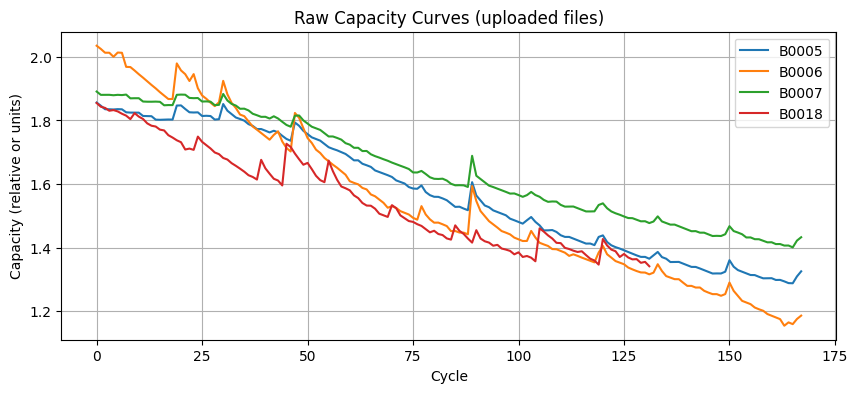

In [ ]:
# ======================================================
# Dataset visualization
# ======================================================

def get_by_key_like(k):
    for fname in file_caps:
        if k.lower() in fname.lower():
            return fname
    raise ValueError(f"File containing '{k}' not found in uploaded files: {list(file_caps.keys())}")

f_b5 = get_by_key_like('B0005')
f_b6 = get_by_key_like('B0006')
f_b7 = get_by_key_like('B0007')
f_b18 = get_by_key_like('B0018')

cap_b5, cap_b6, cap_b7, cap_b18 = file_caps[f_b5], file_caps[f_b6], file_caps[f_b7], file_caps[f_b18]
print("Lengths:", len(cap_b5), len(cap_b6), len(cap_b7), len(cap_b18))

plot_series([cap_b5, cap_b6, cap_b7, cap_b18], labels=['B0005','B0006','B0007','B0018'],
            title='Raw Capacity Curves (uploaded files)')


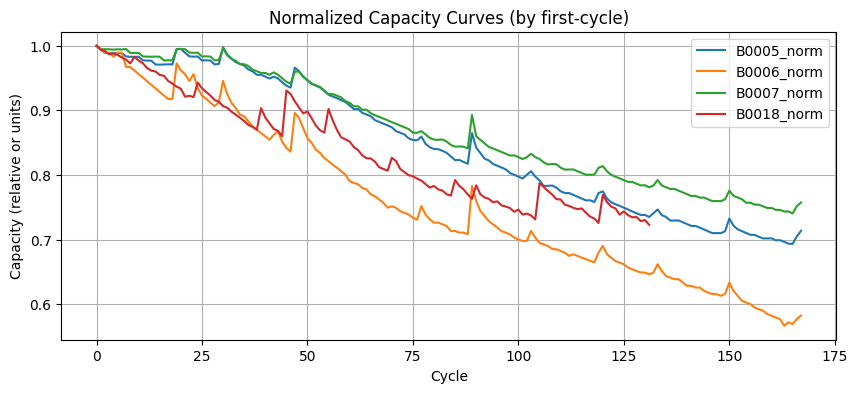

In [ ]:
# ======================================================
# Preprocessing
# ======================================================

cap_b5_n = cap_b5 / cap_b5[0]
cap_b6_n = cap_b6 / cap_b6[0]
cap_b7_n = cap_b7 / cap_b7[0]
cap_b18_n = cap_b18 / cap_b18[0]

plot_series([cap_b5_n, cap_b6_n, cap_b7_n, cap_b18_n],
            labels=['B0005_norm','B0006_norm','B0007_norm','B0018_norm'],
            title='Normalized Capacity Curves (by first-cycle)')


In [ ]:
# ======================================================
# CEEMDAN decomposition on training batteries
# ======================================================

ce = CEEMDAN()
ce.trials = 200
ce.noise_width = 0.2
ce.max_imf = 6

train_caps = [cap_b5_n, cap_b6_n, cap_b7_n]
train_imfs_list = []
for i, cap in enumerate(train_caps):
    print(f"Decomposing train battery {i+1} (len={len(cap)}) ...")
    imfs = ce.ceemdan(cap)
    print("IMFs shape:", imfs.shape)
    train_imfs_list.append(imfs)

test_imfs = ce.ceemdan(cap_b18_n)
print("Test IMFs shape:", test_imfs.shape)


Decomposing train battery 1 (len=168) ...
IMFs shape: (4, 168)
Decomposing train battery 2 (len=168) ...
IMFs shape: (4, 168)
Decomposing train battery 3 (len=168) ...
IMFs shape: (4, 168)
Test IMFs shape: (4, 132)


In [ ]:
# ======================================================
# Training DNN for each IMF
# ======================================================

def create_windows(series, lookback=10):
    X, y = [], []
    for i in range(len(series) - lookback):
        X.append(series[i:i+lookback])
        y.append(series[i+lookback])
    return np.array(X), np.array(y)

lookback = 10
imf_count = train_imfs_list[0].shape[0]

dnn_models = []
imf_train_preds = []
for imf_idx in range(imf_count):
    X_all = []
    y_all = []
    for imfs in train_imfs_list:
        X, y = create_windows(imfs[imf_idx], lookback)
        X_all.append(X)
        y_all.append(y)
    X_all = np.vstack(X_all)
    y_all = np.hstack(y_all)
    print(f"IMF {imf_idx}: X_all shape {X_all.shape}, y_all shape {y_all.shape}")

    scaler_X = MinMaxScaler()
    X_all_s = scaler_X.fit_transform(X_all.reshape(-1, lookback)).reshape(-1, lookback)

    model = Sequential([
        Dense(128, activation='relu', input_shape=(lookback,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_all_s, y_all, epochs=80, batch_size=32, verbose=0,
              callbacks=[EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)])
    dnn_models.append((model, scaler_X))

    pred_train = model.predict(X_all_s).flatten()
    imf_train_preds.append(pred_train)
    print(f"Trained DNN for IMF {imf_idx}")


IMF 0: X_all shape (474, 10), y_all shape (474,)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Trained DNN for IMF 0
IMF 1: X_all shape (474, 10), y_all shape (474,)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Trained DNN for IMF 1
IMF 2: X_all shape (474, 10), y_all shape (474,)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Trained DNN for IMF 2
IMF 3: X_all shape (474, 10), y_all shape (474,)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Trained DNN for IMF 3


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
IMF 0 test pred len: 122
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
IMF 1 test pred len: 122
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
IMF 2 test pred len: 122
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
IMF 3 test pred len: 122
Reconstructed series length: 122


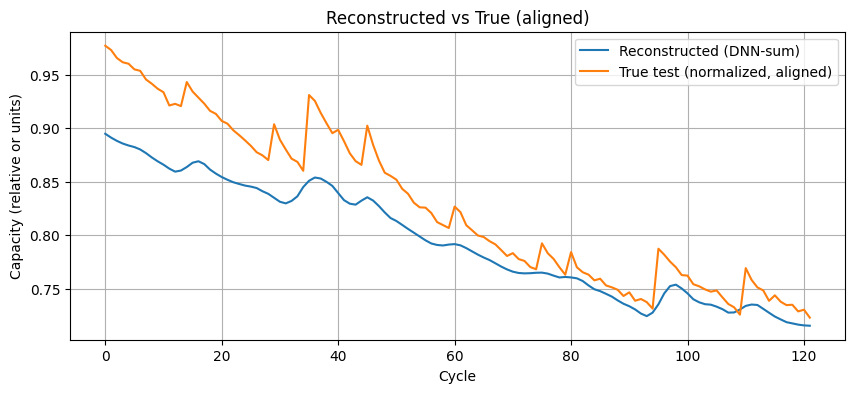

In [ ]:
# ======================================================
# Using each IMF DNN model to predict on the test battery IMFs and reconstruct
# ======================================================
test_imf_preds = []
min_windows = None
for imf_idx, (model, scaler_X) in enumerate(dnn_models):
    imf_series = test_imfs[imf_idx]
    X_test, y_test_true = create_windows(imf_series, lookback)
    # scale using the training IMFs' scaler (important for consistency)
    X_test_s = scaler_X.transform(X_test.reshape(-1, lookback)).reshape(-1, lookback)
    pred = model.predict(X_test_s).flatten()
    test_imf_preds.append(pred)
    if min_windows is None or len(pred) < min_windows:
        min_windows = len(pred)
    print(f"IMF {imf_idx} test pred len: {len(pred)}")

test_imf_preds = np.array(test_imf_preds)[:, :min_windows]
weights = np.linspace(0.4, 1.0, test_imf_preds.shape[0])
recon_series = np.sum(test_imf_preds * weights[:, None], axis=0)

from scipy.signal import savgol_filter
recon_series_sm = savgol_filter(recon_series, window_length=7 if len(recon_series)>=7 else len(recon_series)|1, polyorder=2)

print("Reconstructed series length:", len(recon_series_sm))
plot_series([recon_series_sm, cap_b18_n[lookback:lookback+len(recon_series_sm)]],
            labels=['Reconstructed (DNN-sum)','True test (normalized, aligned)'],
            title='Reconstructed vs True (aligned)')


In [ ]:
# ======================================================
# Preparing BiLSTM training data from reconstructions
# ======================================================
train_recons = []
for imfs in train_imfs_list:
    imf_preds = []
    for imf_idx, (model, scaler_X) in enumerate(dnn_models):
        X_tr, y_tr = create_windows(imfs[imf_idx], lookback)
        X_tr_s = scaler_X.transform(X_tr.reshape(-1, lookback)).reshape(-1, lookback)
        pred_tr = model.predict(X_tr_s).flatten()
        imf_preds.append(pred_tr)
    imf_preds = np.array(imf_preds)[:, :min_windows]
    recon_tr = np.sum(imf_preds * weights[:, None], axis=0)
    recon_tr_sm = savgol_filter(recon_tr, window_length=7 if len(recon_tr)>=7 else len(recon_tr)|1, polyorder=2)
    train_recons.append(recon_tr_sm)

concat_train_recon = np.hstack(train_recons)
print("Concatenated training reconstruction length:", len(concat_train_recon))

def lstm_windows(series, lookback=20):
    X, y = [], []
    for i in range(len(series) - lookback):
        X.append(series[i:i+lookback])
        y.append(series[i+lookback])
    return np.array(X).reshape(-1, lookback, 1), np.array(y)

lstm_lookback = 20
X_train_lstm, y_train_lstm = lstm_windows(concat_train_recon, lstm_lookback)
X_test_lstm, y_test_lstm = lstm_windows(recon_series_sm, lstm_lookback)

print("LSTM train shape:", X_train_lstm.shape, y_train_lstm.shape)
print("LSTM test shape:", X_test_lstm.shape, y_test_lstm.shape)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Concatenated training reconstruction length: 366
LSTM train shape: (346, 20, 1) (346,)
LSTM test shape: (102, 20, 1) (102,)


In [ ]:
# ======================================================
# Scaling LSTM inputs and building BiLSTM model
# ======================================================
scaler_X_lstm = MinMaxScaler()
n_samples, n_steps, _ = X_train_lstm.shape
X_train_flat = X_train_lstm.reshape(-1, n_steps)
X_train_scaled = scaler_X_lstm.fit_transform(X_train_flat).reshape(-1, n_steps, 1)
X_test_flat = X_test_lstm.reshape(-1, n_steps)
X_test_scaled = scaler_X_lstm.transform(X_test_flat).reshape(-1, n_steps, 1)

scaler_y_lstm = MinMaxScaler()
y_train_scaled = scaler_y_lstm.fit_transform(y_train_lstm.reshape(-1,1))
y_test_scaled = scaler_y_lstm.transform(y_test_lstm.reshape(-1,1))

model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(n_steps,1)),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

history = model.fit(X_train_scaled, y_train_scaled,
                    validation_data=(X_test_scaled, y_test_scaled),
                    epochs=200, batch_size=16, verbose=1,
                    callbacks=[es, rlr])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.1423 - val_loss: 0.0121 - learning_rate: 0.0010
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0206 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0167 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0162 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0125 - val_loss: 8.1129e-04 - learning_rate: 0.0010
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0116 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 7/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0117 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 8/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0105 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 9/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0101 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 379ms/step
BiLSTM Test RMSE: 0.006132 (on normalized capacity scale)
BiLSTM Test R^2: 0.9812


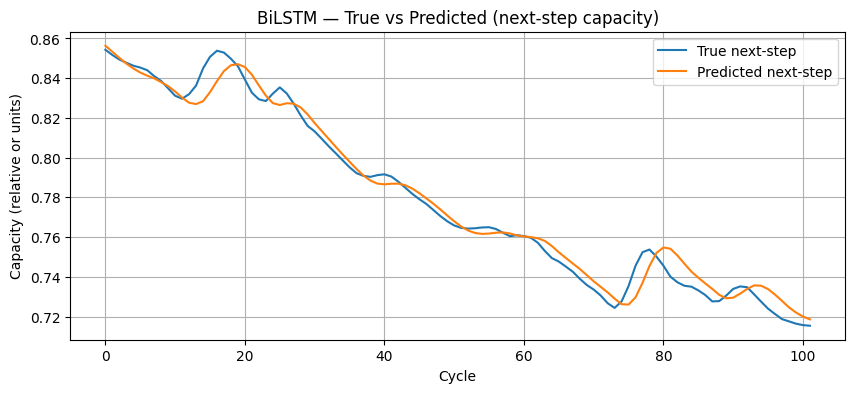

In [ ]:
# ======================================================
# Evaluation and Performance Metrics (RMSE/R2)
# ======================================================
# Predict on test set
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y_lstm.inverse_transform(y_pred_scaled).flatten()
y_true = y_test_lstm.flatten()

rmse = math.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
print(f"BiLSTM Test RMSE: {rmse:.6f} (on normalized capacity scale)")
print(f"BiLSTM Test R^2: {r2:.4f}")

# Plot a chunk
plot_series([y_true, y_pred], labels=['True next-step','Predicted next-step'],
            title='BiLSTM — True vs Predicted (next-step capacity)')


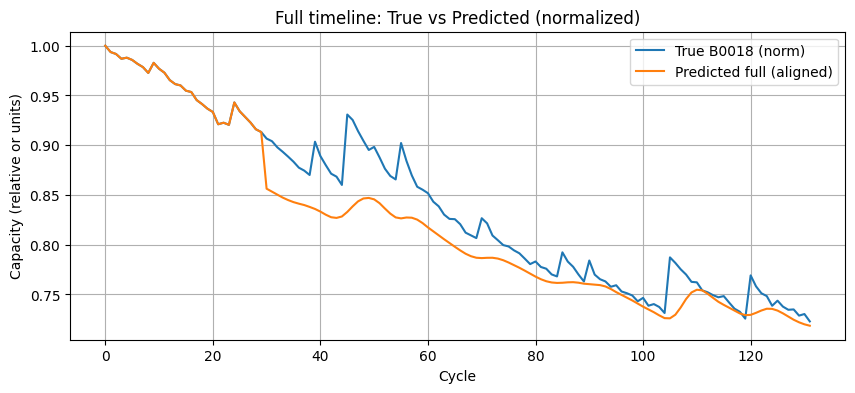

Estimated RUL (cycles until normalized capacity < 0.75): 96 cycles (index 96).


In [ ]:
# ======================================================
# Cell 12 — Full reconstructed predicted capacity for B0018 and RUL estimate
# ======================================================

start_idx = lookback + lstm_lookback
pred_timeline = np.full(len(cap_b18_n), np.nan)

for i, val in enumerate(y_pred):
    idx = start_idx + i
    if idx < len(pred_timeline):
        pred_timeline[idx] = val

filled_pred = pred_timeline.copy()
filled_pred[:start_idx] = cap_b18_n[:start_idx]
last_valid = np.nanmax(np.where(~np.isnan(filled_pred), np.arange(len(filled_pred)), -1))
if last_valid >= 0 and last_valid < len(filled_pred)-1:
    filled_pred[last_valid+1:] = filled_pred[last_valid]

plot_series([cap_b18_n, filled_pred], labels=['True B0018 (norm)','Predicted full (aligned)'],
            title='Full timeline: True vs Predicted (normalized)')

threshold = 0.75
below_idx = np.where(filled_pred < threshold)[0]
if below_idx.size == 0:
    print("Predicted never reaches threshold within observed cycles (increase horizon or check predictions).")
else:
    failure_idx = below_idx[0]
    current_cycle = 0
    rul_est = failure_idx - current_cycle
    print(f"Estimated RUL (cycles until normalized capacity < {threshold}): {rul_est} cycles (index {failure_idx}).")
